In [46]:
import random as random
import numpy as np

class Layer:
    def __init__(self, currentLayerLen):
        self.activationVector = np.array([random.uniform(0, 0.1) for i in range(currentLayerLen)])
        self.biasVector = np.array([random.uniform(-1.0, 0.0) for i in range(currentLayerLen)])
        self.adjBiasVector = np.zeros(currentLayerLen)
        self.zVector = np.zeros(shape = (currentLayerLen, 1))
        self.errorVector = np.zeros(shape = (currentLayerLen, 1))
        self.size = currentLayerLen

    def resetLayer(self):
        self.zVector = np.zeros(self.zVector.size)
        self.errorVector = np.zeros(self.errorVector.size)

    def resetAdjBiasVector(self):
        self.adjBiasVector = np.zeros(self.biasVector.size)

    def cout(self):
        print("Activations: ")
        print(self.activationVector)
        print("Biases: ")
        print(self.biasVector)
        print("Z Vector: ")
        print(self.zVector)
        print("Error: ")
        print(self.errorVector)

    def coutBase(self):
        print("Activations: ")
        print(self.activationVector)
        print("Biases: ")
        print(self.biasVector)

In [47]:
class weightMatrix:
    def __init__(self, prevLayerLen, nextLayerLen):
        self.matrix = np.random.rand(nextLayerLen, prevLayerLen) * 0.001
        self.adjMatrix = np.zeros((nextLayerLen, prevLayerLen))

    def resetAdjMatrix(self):
        self.adjMatrix = np.zeros((self.matrix.shape))

    def cout(self):
        print(self.matrix)

In [48]:
import matplotlib.pyplot as plt

# Helper function to show a list of images with their relating titles
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1

In [49]:
def sigmoid(x):
    if x <= -700:
        x = -700
    return 1 / (1 + np.exp(-x))

def sigmoidDeriv(x):
    if x <= -350:
        x = -350
    return np.exp(-x) / ((1 + np.exp(-x)) * (1 + np.exp(-x)))

class Network:

    # The class is currently set up to only support exactly 4 deep neural networks
    def __init__(self, start, first, second, end):
        startLayer = Layer(start)
        firstLayer = Layer(first)
        secondLayer = Layer(second)
        endLayer = Layer(end)

        self.Layers = np.array([startLayer, firstLayer, secondLayer, endLayer])

        firstMatrix = weightMatrix(start, first)
        secondMatrix = weightMatrix(first, second)
        endMatrix = weightMatrix(second, end)

        # Indexed with the layer before the matrix
        self.Matrices = np.array([firstMatrix, secondMatrix, endMatrix])

    def calculateZVector(self, layerIdx):
        # self.Layers[layerIdx - 1] is previous Layer
        # currLayer = self.Layers[layerIdx] is current Layer
        # self.Matrices[layerIdx - 1].matrix is weight matrix related to this calculation
        # self.Layers[layerIdx - 1].activationVector is previous activation
        # self.Layers[layerIdx].biasVector is current Bias

        # Weight matrix * previous activation vector
        self.Layers[layerIdx].zVector = np.dot(self.Matrices[layerIdx - 1].matrix, self.Layers[layerIdx - 1].activationVector)
        # += current bias vector
        self.Layers[layerIdx].zVector += self.Layers[layerIdx].biasVector

    def forwardPropagationStep(self, layerIdx):
        # currLayer = self.Layers[layerIdx] is current Layer

        self.calculateZVector(layerIdx)

        # Apply sigmoid in place
        for i in range(self.Layers[layerIdx].size):
            self.Layers[layerIdx].activationVector[i] = sigmoid(self.Layers[layerIdx].zVector[i])

    # Assumes that data is between 0 and 255 value
    def setStartLayerActivations(self, dataset):
        # self.Layers[0] is start Layer

        # Dataset is in 2D array but the first layer expects a vector
        if len(dataset) * len(dataset[0]) != self.Layers[0].size:
            print("There is a mismatch between the size of the input data and the start layer!")
            print("Size of dataset is: " + str(len(dataset) * len(dataset[0])))
            print("Size of first layer is: " + str(self.Layers[0].size))

        layerIdx = 0
        for row in range(0, len(dataset)):
            for col in range(0, len(dataset[0])):
                self.Layers[0].activationVector[layerIdx] = dataset[row][col] / 255
                layerIdx += 1

    def fullForwardPropagation(self, target):
        self.forwardPropagationStep(1)
        self.forwardPropagationStep(2)
        self.forwardPropagationStep(3)
    
    def cost(self, target):
        # self.Layers[self.Layers.size - 1] is end Layer

        sum = 0

        for i in range(self.Layers[self.Layers.size - 1].size):
            if (i == target):
                sum += (1.0 - self.Layers[self.Layers.size - 1].activationVector[i]) * (1.0 - self.Layers[self.Layers.size - 1].activationVector[i])
            else:
                sum += (self.Layers[self.Layers.size - 1].activationVector[i]) * (self.Layers[self.Layers.size - 1].activationVector[i])
        return sum / (self.Layers[self.Layers.size - 1].size)
    
    def fullBackwardPropagation(self, target):
        self.calculateErrorInLastLayerForTarget(target)

        # Iterate error back from last layer
        for idx in range(self.Layers.size - 2, 0, -1):
            self.calculateErrorFromNextLayerError(idx)
    
    # The cost function is hard coded, and it is quadratic
    def calculateErrorInLastLayerForTarget(self, target):
        # self.Layers[self.Layers.size - 1] is end Layer

        # Creating the CGradient vector based on hard coded cost function
        CGradient = np.zeros(self.Layers[self.Layers.size - 1].size)
        for i in range(self.Layers[self.Layers.size - 1].size):
            CGradient[i] = self.Layers[self.Layers.size - 1].activationVector[i]
            # The desired value for target is 1
            if i == target:
                CGradient[i] -= 1.0

        # Apply sigmoid' to endLayer.zVector in place
        for i in range(self.Layers[self.Layers.size - 1].size):
            self.Layers[self.Layers.size - 1].zVector[i] = sigmoidDeriv(self.Layers[self.Layers.size - 1].zVector[i])

        # sigmoid' was applied to endLayer.zVector in place
        self.Layers[self.Layers.size - 1].errorVector = np.multiply(CGradient, self.Layers[self.Layers.size - 1].zVector)

    # Assumes error in next layer is up to date
    def calculateErrorFromNextLayerError(self, layerIdx):
        # self.Layers[layerIdx] is current Layer
        # self.Layers[layerIdx + 1] is next Layer

        # self.Matrices[layerIdx].matrix.transpose() is the transposed weight matrix
        # np.dot(transposedWeightMatrix, self.Layers[layerIdx + 1].errorVector) is transposed weight matrix * next layer error

        # Apply sigmoid' to currLayer.zVector in place
        for i in range(self.Layers[layerIdx].size):
            self.Layers[layerIdx].zVector[i] = sigmoidDeriv(self.Layers[layerIdx].zVector[i])

        # sigmoid' was applied to self.Layers[self.Layers.size - 1].zVector in place
        # error = (transposed weight matrix * next layer error) o sigmoid'(z)
        # Where o is index by index multiplication
        self.Layers[layerIdx].errorVector = np.multiply(np.dot(self.Matrices[layerIdx].matrix.transpose(), self.Layers[layerIdx + 1].errorVector), self.Layers[layerIdx].zVector)

    def adjustBasedOnGradientDescentForCurrentExample(self, learningRate, numberInBatch):
        # npm stands for n per m
        # where: n: learning rate
        #        m: number of train examples in batch
        npm = learningRate / numberInBatch

        # Adjust biases
        for layerIdx in range(1, self.Layers.size):
            # self.Layers[layerIdx] is current Layer

            # We will subtract the adjBiasVector from the corresponding bias vector in the adjustWithAdjustVariables function
            self.Layers[layerIdx].adjBiasVector += npm * self.Layers[layerIdx].errorVector

        # # Adjust weights
        for weightMatrixIdx in range(self.Matrices.size):
            # self.Matrices[weightMatrixIdx].matrix is current weight matrix
            # self.Layers[weightMatrixIdx + 1] is current Layer
            # self.Layers[weightMatrixIdx] is previous Layer
            
            # We will subtract the adjMatrix from the corresponding weight matrix in the adjustWithAdjustVariables function
            self.Matrices[weightMatrixIdx].adjMatrix += npm * np.dot(np.array([self.Layers[weightMatrixIdx + 1].errorVector]).transpose(), np.array([self.Layers[weightMatrixIdx].activationVector]))

    def trainBatch(self, data, labels, learningRate):
        # Check if there is a length mismatch between data and labels
        if (len(data) != len(labels)):
            print("There is a mismatch between the length of the data and lables")
            print("Length of data is: " + str(data.size))
            print("Length of labels are: " + str(labels.size))

        numberInBatch = len(data)
        self.resetAdjs()

        for idx in range(numberInBatch):
            self.resetNetwork()
            self.setStartLayerActivations(data[idx])
            self.fullForwardPropagation(labels[idx])
            self.fullBackwardPropagation(labels[idx])
            self.adjustBasedOnGradientDescentForCurrentExample(learningRate, numberInBatch)

        self.adjustWithAdjustVariables()

    # Reset everything in network EXCEPT for adj biases and matrices
    def resetNetwork(self):
        for layer in self.Layers:
            layer.resetLayer()

    # Reset the adj biases and matrices
    def resetAdjs(self):
        for layer in self.Layers:
            layer.resetAdjBiasVector()

        for matrix in self.Matrices:
            matrix.resetAdjMatrix()
    
    # Adjust biases and matrices with the calculated values
    def adjustWithAdjustVariables(self):
        for layerIdx in range(1, self.Layers.size):
            self.Layers[layerIdx].biasVector -= self.Layers[layerIdx].adjBiasVector

        for weightMatrixIdx in range(self.Matrices.size):
            self.Matrices[weightMatrixIdx].matrix -= self.Matrices[weightMatrixIdx].adjMatrix

    # Can only be used after forward propagation
    def findPrediction(self):
        # self.Layers[self.Layers.size - 1].activationVector is last layer

        max = 0
        maxIdx = 0

        for idx in range(self.Layers[self.Layers.size - 1].activationVector.size):
            if self.Layers[self.Layers.size - 1].activationVector[idx] > max:
                max = self.Layers[self.Layers.size - 1].activationVector[idx]
                maxIdx = idx

        return maxIdx

    # Test network, find average cost and percentage of correct predictions
    def test(self, data, labels):
        # Check if there is a length mismatch between data and label
        if (len(data) != len(labels)):
            print("There is a mismatch between the length of the data and lables")
            print("Length of data is: " + str(data.size))
            print("Length of labels are: " + str(labels.size))

        numberOfTest = len(data)
        sumCost = 0
        correct = 0

        for idx in range(numberOfTest):
            self.setStartLayerActivations(data[idx])
            self.fullForwardPropagation(labels[idx])

            sumCost += self.cost(labels[idx])

            correctIdx = self.findPrediction()
            if correctIdx == labels[idx]:
                correct += 1

        print("Average cost is: ", sumCost / numberOfTest)
        print("Percentage of correct is: ", correct / numberOfTest)

    # Get random examples and print expected value and the activation of the last layer
    def checkRandomExamples(self, data, labels):
        images_2_show = []
        titles_2_show = []

        numberOfData = len(data)

        for i in range (20):
            randIdx = random.randint(0, numberOfData)
            
            self.setStartLayerActivations(data[randIdx])
            self.fullForwardPropagation(labels[randIdx])
            pred = self.findPrediction()

            print("Index: " + str(i) + " Label: " + str(labels[randIdx]) + " Prediction: " + str(pred) + " Cost: " + str(self.cost(labels[randIdx])))
            self.coutLastLayer()
            images_2_show.append(data[randIdx])
            titles_2_show.append("Idx: " + str(i) + " Prediction: " + str(pred))
        
        show_images(images_2_show, titles_2_show)

    # Prints last layer activations with its labels
    def coutLastLayer(self):
        print("The last layer activations are: ")
        for idx in range(self.Layers[self.Layers.size - 1].activationVector.size):
            print(idx, ":", self.Layers[self.Layers.size - 1].activationVector[idx])
            
    # Print activations of each layer
    def coutActivation(self):
        for idx in range(self.Layers.size):
            print("Layer: " + str(idx))
            print(self.Layers[idx].activationVector)

    # Print activations, biases and matrices
    def coutBase(self):
        for i in range(self.Matrices.size):
            print("Layer: ", i)
            self.Layers[i].coutBase()
            print()
            self.Matrices[i].cout()
            print()

        print("Layer: ", self.Layers.size - 1)
        self.Layers[self.Layers.size - 1].coutBase()

    # Print all values in network
    def cout(self):
        for i in range(self.Matrices.size):
            print("Layer: ", i)
            self.Layers[i].cout()
            print()
            self.Matrices[i].cout()
            print()

        print("Layer: ", self.Layers.size - 1)
        self.Layers[self.Layers.size - 1].cout()

Average cost is:  0.012255575622968024
Percentage of correct is:  0.9279
Index: 0 Label: 4 Prediction: 4 Cost: 4.234585810085902e-07
The last layer activations are: 
0 : 1.2782873090944961e-07
1 : 0.0008287039527848794
2 : 0.0001248889597733344
3 : 8.3211845705313e-11
4 : 0.9992109814171871
5 : 2.654538464582012e-05
6 : 0.0015500369574504376
7 : 1.179444604509362e-06
8 : 7.4938191422299715e-06
9 : 0.0007115554797512242
Index: 1 Label: 4 Prediction: 4 Cost: 8.92052190661082e-05
The last layer activations are: 
0 : 0.00012250851164426356
1 : 0.0008251514209211266
2 : 8.442817829808004e-08
3 : 7.218216805966358e-08
4 : 0.988940395624919
5 : 0.0014721663703375584
6 : 3.5394623511261146e-07
7 : 3.4120537370004016e-05
8 : 3.381969648640854e-05
9 : 0.027692451617406272
Index: 2 Label: 4 Prediction: 4 Cost: 9.763736377094246e-05
The last layer activations are: 
0 : 2.532208722223748e-06
1 : 0.0013042718385345173
2 : 0.0006638343886961381
3 : 9.756836410462606e-09
4 : 0.9724468277346342
5 : 5.7

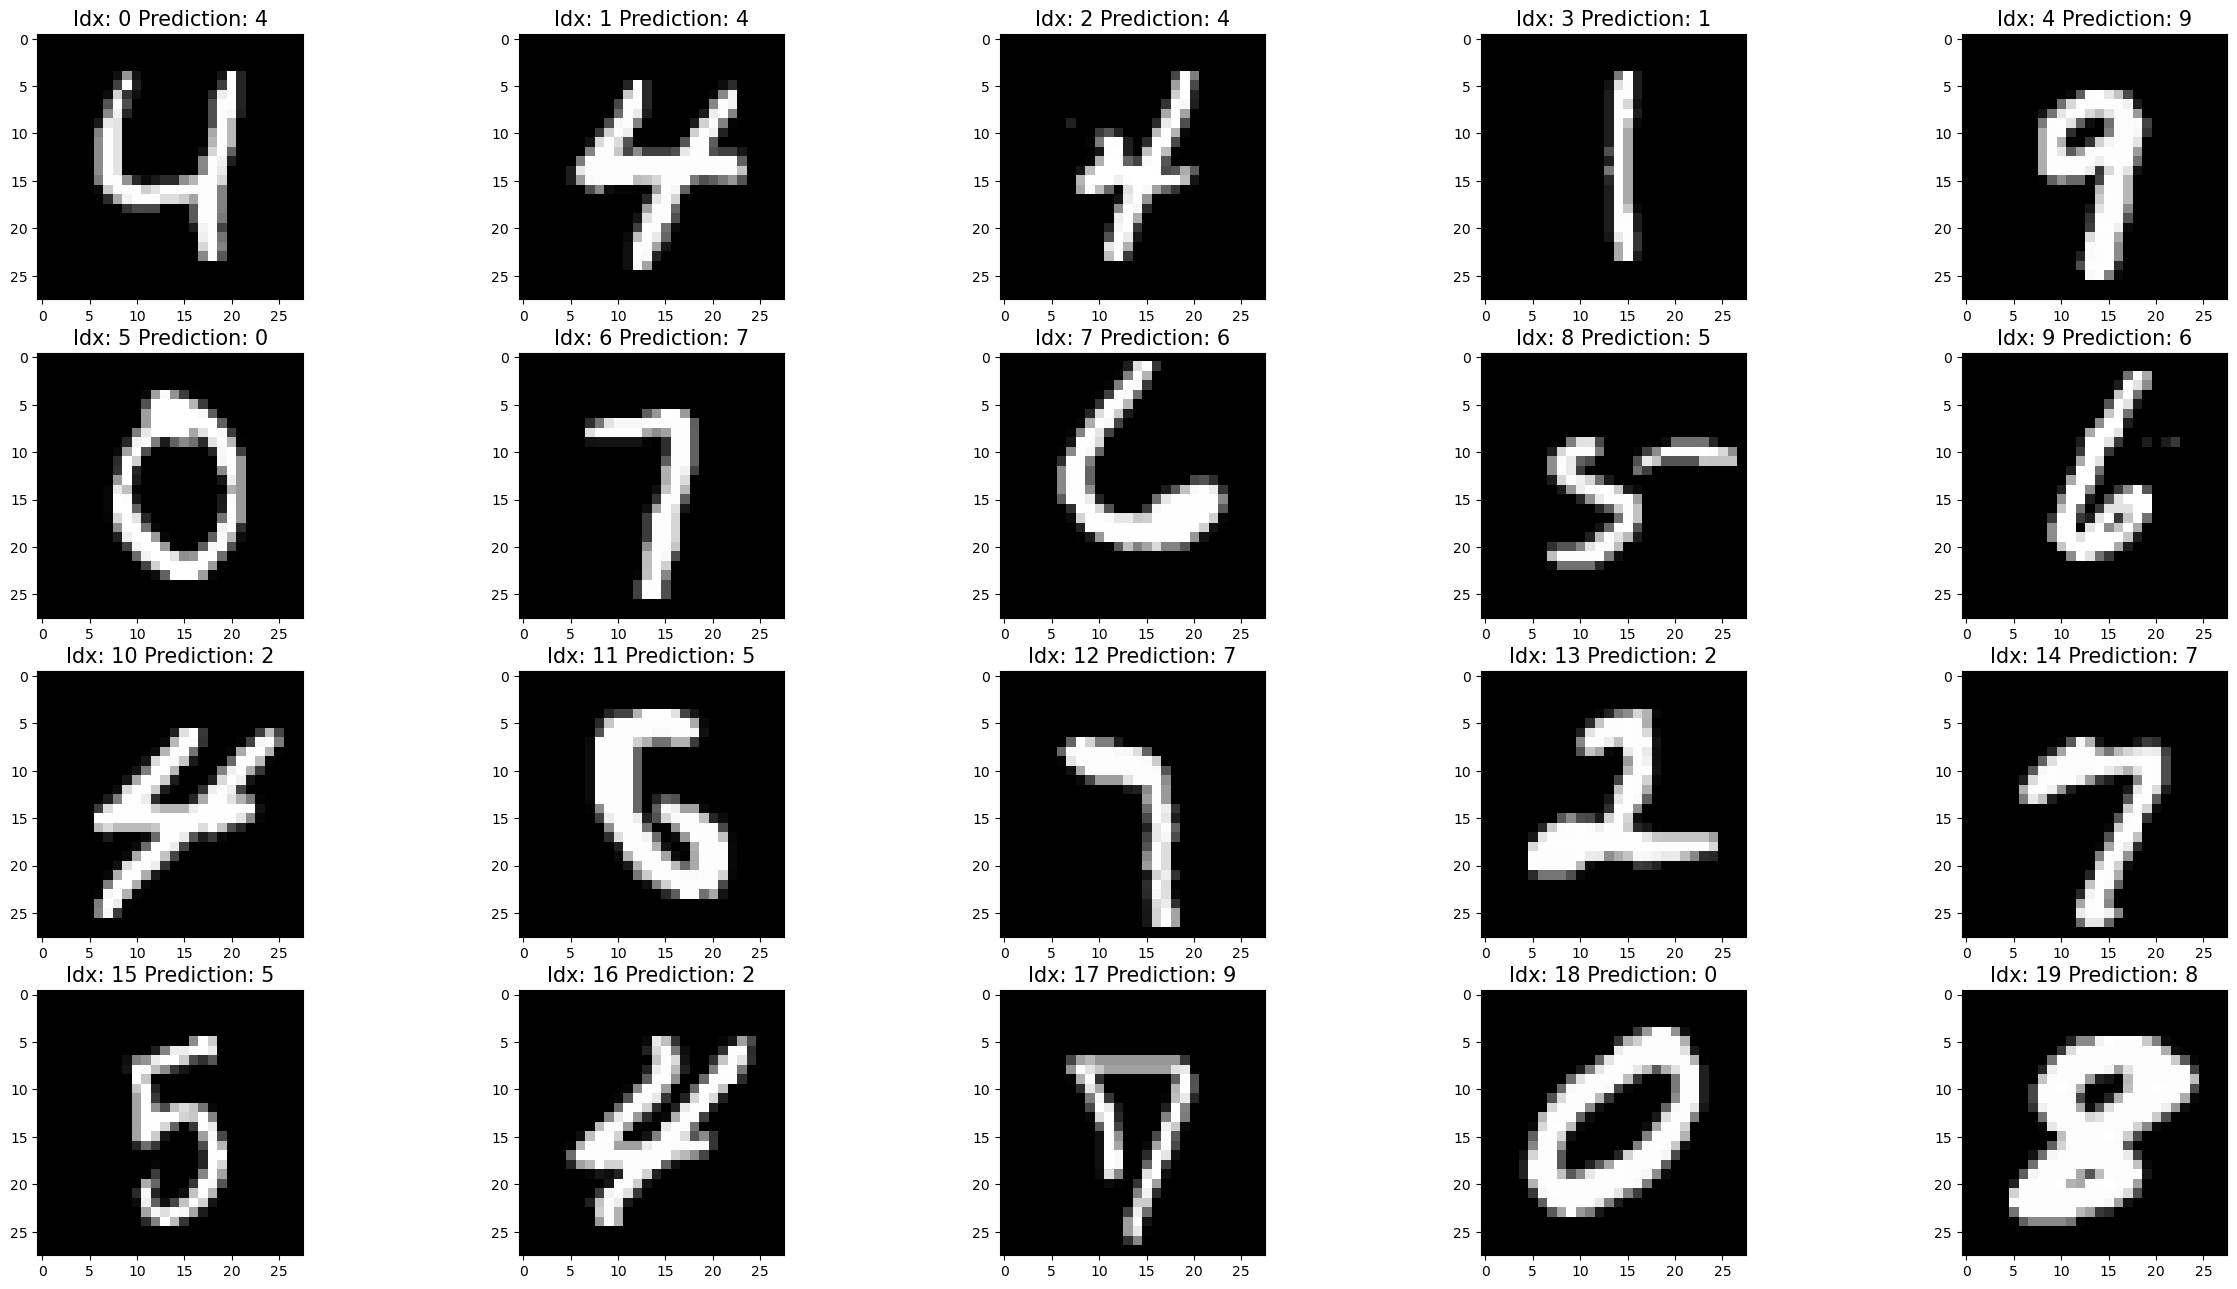

In [50]:
import pickle

# Load network
with open("network.pickle", "rb") as infile:
    net = pickle.load(infile)

# Load test data and labels
with open("dataset/pickled/data_test.pickle", "rb") as infile:
    data_test = pickle.load(infile)
with open("dataset/pickled/label_test.pickle", "rb") as infile:
    label_test = pickle.load(infile)

training = False
testing = True

if training:
    # Loading training batches
    with open("dataset/pickled/data_batch_01.pickle", "rb") as infile:
        data_batch_01 = pickle.load(infile)
    with open("dataset/pickled/label_batch_01.pickle", "rb") as infile:
        label_batch_01 = pickle.load(infile)
    with open("dataset/pickled/data_batch_02.pickle", "rb") as infile:
        data_batch_02 = pickle.load(infile)
    with open("dataset/pickled/label_batch_02.pickle", "rb") as infile:
        label_batch_02 = pickle.load(infile)
    with open("dataset/pickled/data_batch_03.pickle", "rb") as infile:
        data_batch_03 = pickle.load(infile)
    with open("dataset/pickled/label_batch_03.pickle", "rb") as infile:
        label_batch_03 = pickle.load(infile)
    with open("dataset/pickled/data_batch_04.pickle", "rb") as infile:
        data_batch_04 = pickle.load(infile)
    with open("dataset/pickled/label_batch_04.pickle", "rb") as infile:
        label_batch_04 = pickle.load(infile)
    with open("dataset/pickled/data_batch_05.pickle", "rb") as infile:
        data_batch_05 = pickle.load(infile)
    with open("dataset/pickled/label_batch_05.pickle", "rb") as infile:
        label_batch_05 = pickle.load(infile)
    with open("dataset/pickled/data_batch_01.pickle", "rb") as infile:
        data_batch_06 = pickle.load(infile)
    with open("dataset/pickled/label_batch_01.pickle", "rb") as infile:
        label_batch_06 = pickle.load(infile)
    with open("dataset/pickled/data_batch_02.pickle", "rb") as infile:
        data_batch_07 = pickle.load(infile)
    with open("dataset/pickled/label_batch_02.pickle", "rb") as infile:
        label_batch_07 = pickle.load(infile)
    with open("dataset/pickled/data_batch_03.pickle", "rb") as infile:
        data_batch_08 = pickle.load(infile)
    with open("dataset/pickled/label_batch_03.pickle", "rb") as infile:
        label_batch_08 = pickle.load(infile)
    with open("dataset/pickled/data_batch_04.pickle", "rb") as infile:
        data_batch_09 = pickle.load(infile)
    with open("dataset/pickled/label_batch_04.pickle", "rb") as infile:
        label_batch_09 = pickle.load(infile)
    with open("dataset/pickled/data_batch_05.pickle", "rb") as infile:
        data_batch_10 = pickle.load(infile)
    with open("dataset/pickled/label_batch_05.pickle", "rb") as infile:
        label_batch_10 = pickle.load(infile)
    
    # Testing before training
    print("Testing on test data:")
    net.test(data_test, label_test)

    # Training
    for i in range(200):
        # Number in one batch is 6000 so a learning rate of 6000 will result in an npm of 1
        net.trainBatch(data_batch_01, label_batch_01, 60)
        net.trainBatch(data_batch_02, label_batch_02, 60)
        net.trainBatch(data_batch_03, label_batch_03, 60)
        net.trainBatch(data_batch_04, label_batch_04, 60)
        net.trainBatch(data_batch_05, label_batch_05, 60)
        net.trainBatch(data_batch_06, label_batch_06, 60)
        net.trainBatch(data_batch_07, label_batch_07, 60)
        net.trainBatch(data_batch_08, label_batch_08, 60)
        net.trainBatch(data_batch_09, label_batch_09, 60)
        net.trainBatch(data_batch_10, label_batch_10, 60)

    # Testing after training
    print("Testing on test data:")
    net.test(data_test, label_test)

    # Write trained network into its file
    with open("network.pickle", "wb") as outfile:
        pickle.dump(net, outfile)

if testing:
    # Test network
    net.test(data_test, label_test)
    # See random examples
    net.checkRandomExamples(data_test, label_test)